# 3. Entrenamiento y testeo

In [86]:
# Importar paquetes necesarios
import sys
sys.path.append('../..')

import string
import unicodedata
!pip install stop_words
from stop_words import get_stop_words

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import sys
sys.path.append('../..')

import random
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

You should consider upgrading via the 'C:\Users\Seven\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Seven\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [87]:
# Datos descargados de http://jmcauley.ucsd.edu/data/amazon/
# ! unzip datasets.zip

import zipfile
with zipfile.ZipFile("datasets.zip", "r") as z:
    z.extractall(".")

In [88]:
datasets_path = 'datasets'
instruments_json = 'reviews_Musical_Instruments_5.json.gz'
df_instruments = pd.read_json(os.path.join(datasets_path, instruments_json), lines = True, compression = 'gzip')

# Subconjunto de características 'reviewText' y 'overall'
reviews = df_instruments[['reviewText', 'overall']]

reviews.head(3)

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5


C:\Users\Seven\AppData\Local\Temp\ipykernel_8400\763786958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.loc[:, 'sentiment'] = [0 if overall <= 3 else 1 for overall in reviews['overall']]


<AxesSubplot:title={'center':'Overall sentiment distribution'}>

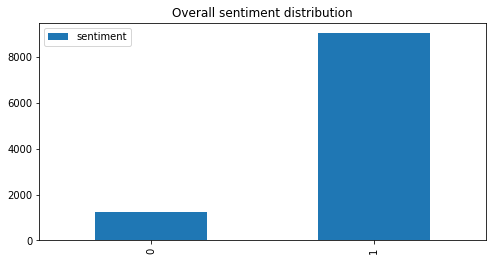

In [89]:
# Personalmente creo que 3 es una review negativa
reviews.loc[:, 'sentiment'] = [0 if overall <= 3 else 1 for overall in reviews['overall']]
aux = pd.DataFrame(reviews['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall sentiment distribution', figsize=(8, 4))

ax

In [90]:
# Balanceo de clases
df_positive = reviews[reviews['sentiment'] == 1]
df_negative = reviews[reviews['sentiment'] == 0]

data_instruments = reviews.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), df_negative.shape[0])))

<AxesSubplot:title={'center':'Overall sentiment distribution'}>

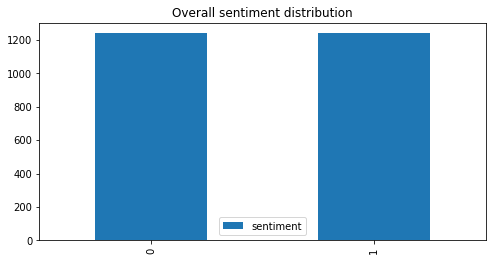

In [91]:
aux = pd.DataFrame(data_instruments['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall sentiment distribution', figsize=(8, 4))

ax

## Análisis de sentimiento usando VADER

Usaremos VADER para caracterizar el corpus y ver el histograma de polaridad de las reviews.


In [92]:
vader_analyser = SentimentIntensityAnalyzer()

In [93]:
review_neg = data_instruments[data_instruments['sentiment'] == 0].sample(1)['reviewText'].values[0]

print(review_neg)
print(vader_analyser.polarity_scores(review_neg))

I like this preamp. I use one channel for microphone and the other for an electric guitar with good results.Is very sadly and spendthrift that its useful life will be the duration of its tube, another concept of producci&oacute;n nothing considered with consumer and planet.
{'neg': 0.059, 'neu': 0.783, 'pos': 0.158, 'compound': 0.6378}


In [94]:
review_pos = data_instruments[data_instruments['sentiment'] == 1].sample(1)['reviewText'].values[0]

print(review_pos)
print(vader_analyser.polarity_scores(review_pos))

When I found that my USB microphone cannot stand on the tripod that came with it, I was so glad that I bought this stand along with the mic based on all the positive reviews. This stand is basically dead weight. That's exactly what I wanted from a desk stand.
{'neg': 0.073, 'neu': 0.8, 'pos': 0.127, 'compound': 0.4882}


In [95]:
# Función VADER para detectar sentimiento
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Ejecución
data_instruments['vader_polarity'] = data_instruments['reviewText'].apply(vader_sentiment)

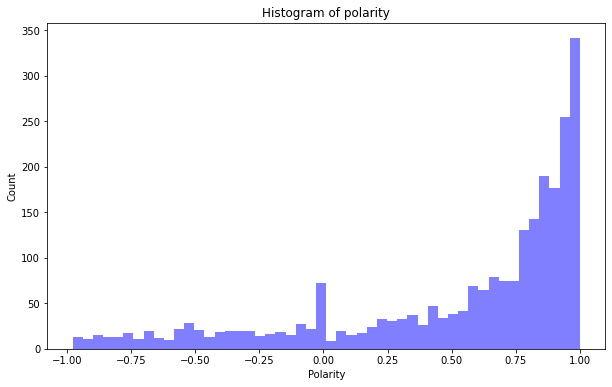

In [96]:
# Comprobar la distribución de los resultados de sentimiento del vendedor
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data_instruments.vader_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')

plt.show();

Con VADER es muy fácil tener una estimación del sentimiento generral de los usuarios muy rápidamente.

In [97]:
# Preprocesado
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

lemmas_path = 'datasets'
english_lemmas = 'lemmatization.txt'

english_lemmas_dict = get_lemmas_dict(lemmas_path, english_lemmas)
sw_list = get_stop_words('english')


def text_normalizer(text, lemmas_dict=None, sw_list=None):

    processed_text = []

    if sw_list is None:
        sw_list = []

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar dígitos
    text = ''.join([c for c in text if not c.isdigit()])

    # Eliminar carácteres extraños
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Eliminar puntuación
    table = str.maketrans('', '', string.punctuation)

    # Dividir en sentencias
    sentences = text.split('.')

    for sentence in sentences:
        words = sentence.split(' ')
        for word in words:
            if word not in sw_list:
                if word not in string.punctuation:
                    word = word.translate(table)
                    if lemmas_dict is not None:
                        word = lemmas_dict.get(word, word)
                processed_text.append(word)

    return ' '.join(processed_text)

In [98]:
# Nueva columna con texto procesado
data_instruments['processed_text'] = data_instruments['reviewText'].apply(lambda text: text_normalizer(text=text, lemmas_dict=english_lemmas_dict, sw_list=sw_list))

data_instruments.head()

,reviewText,overall,sentiment,vader_polarity,processed_text
8107,It works but shut it down as soon as you are f...,3,0,-0.1154,work shut soon finish tune eat battery like n...
6218,"Unhappy with it, actually I already replaced t...",1,0,-0.2672,unhappy it actually already replace method at...
9964,It only cost around $20 so my expectations wer...,3,0,0.0000,cost around $ expectation high begin right box...
1178,It is not the size for mini guitar. May be for...,2,0,-0.0258,size mini guitar may big one connection sha...
3145,I can't believe these were actually sent to me...,1,0,0.9583,believe actually send head small normal pickg...


**Modelo 1: Regresión logística con texto sin procesar**

In [99]:
reviews.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    data_instruments['reviewText'],
    data_instruments['sentiment'],
    train_size=0.80,
    test_size=0.20,
    random_state=17,
    shuffle=True
)

C:\Users\Seven\AppData\Local\Temp\ipykernel_8400\2453639723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.dropna(inplace=True)


In [100]:
# TFIdvectorizer
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

In [101]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [102]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print (f"Accuracy for C={c}: {accuracy_score(y_test, test_predict)}")

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.5645161290322581
Accuracy for C=0.05: 0.7036290322580645
Accuracy for C=0.25: 0.7459677419354839
Accuracy for C=0.5: 0.7459677419354839
Accuracy for C=1: 0.7419354838709677
Accuracy for C=10: 0.7258064516129032
Accuracy for C=100: 0.7076612903225806
Accuracy for C=1000: 0.6975806451612904
Accuracy for C=10000: 0.6915322580645161


In [103]:
print(f"Confussion matrix:\n{confusion_matrix(y_test, test_predict)}")
print(f"\nClassification report:\n{classification_report(y_test, test_predict)}")
print(f"Accuracy score:{accuracy_score(y_test, test_predict)}")

Confussion matrix:
[[182  84]
 [ 69 161]]

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       266
           1       0.66      0.70      0.68       230

    accuracy                           0.69       496
   macro avg       0.69      0.69      0.69       496
weighted avg       0.69      0.69      0.69       496

Accuracy score:0.6915322580645161


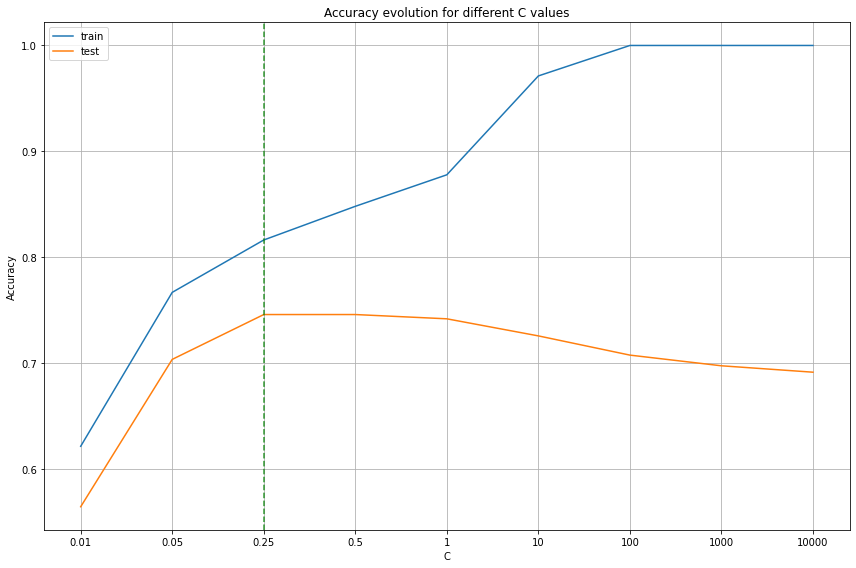

In [104]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()

plt.show()

**Modelo 2: Regresión logística con texto procesado**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    data_instruments['processed_text'],
    data_instruments['sentiment'],
    train_size=0.80,
    test_size=0.20,
    random_state=17,
    shuffle=True
)

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)

cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [106]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print (f"Accuracy for C={c}: {accuracy_score(y_test, test_predict)}")

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.4959677419354839
Accuracy for C=0.05: 0.6814516129032258
Accuracy for C=0.25: 0.7076612903225806
Accuracy for C=0.5: 0.717741935483871
Accuracy for C=1: 0.7076612903225806
Accuracy for C=10: 0.6754032258064516
Accuracy for C=100: 0.6451612903225806
Accuracy for C=1000: 0.6229838709677419
Accuracy for C=10000: 0.6108870967741935


In [107]:
print(f"Confussion matrix:\n{confusion_matrix(y_test, test_predict)}")
print(f"\nClassification report:\n{classification_report(y_test, test_predict)}")
print(f"Accuracy score:{accuracy_score(y_test, test_predict)}")

Confussion matrix:
[[163 103]
 [ 90 140]]

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       266
           1       0.58      0.61      0.59       230

    accuracy                           0.61       496
   macro avg       0.61      0.61      0.61       496
weighted avg       0.61      0.61      0.61       496

Accuracy score:0.6108870967741935


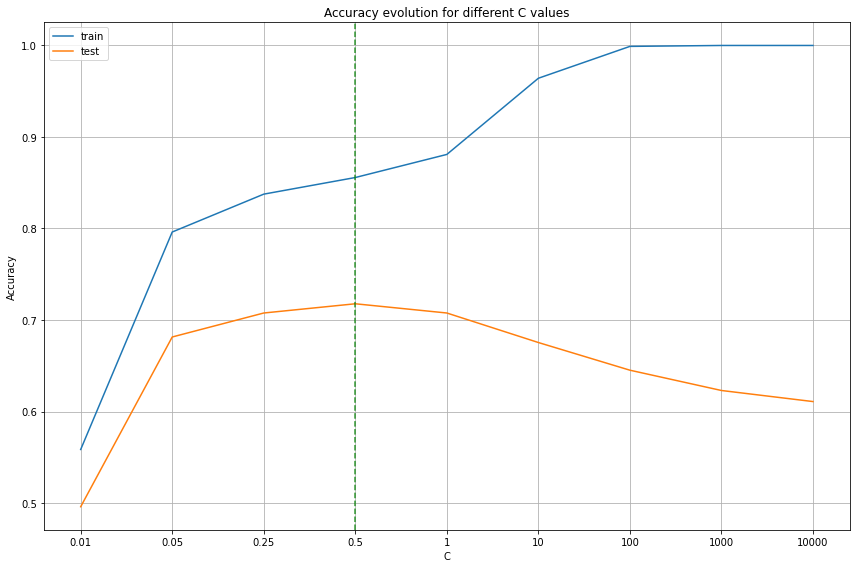

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()

plt.show()

**Modelo 3: Random Forest con texto procesado**

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    data_instruments['processed_text'],
    data_instruments['sentiment'],
    train_size=0.80,
    test_size=0.20,
    random_state=17,
    shuffle=True
)

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)

cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [110]:
from sklearn.ensemble import RandomForestClassifier

c_params = [10, 50, 100]

train_acc = list()
test_acc = list()

for c in c_params:
    rf = RandomForestClassifier(n_estimators=c)
    rf.fit(X_train_, y_train)

    train_predict = rf.predict(X_train_)
    test_predict = rf.predict(X_test_)

    print (f"Accuracy for C={c}: {accuracy_score(y_test, test_predict)}")

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=10: 0.6653225806451613
Accuracy for C=50: 0.6955645161290323
Accuracy for C=100: 0.7036290322580645


In [85]:
print(f"Confussion matrix:\n{confusion_matrix(y_test, test_predict)}")
print(f"\nClassification report:\n{classification_report(y_test, test_predict)}")
print(f"Accuracy score:{accuracy_score(y_test, test_predict)}")

Confussion matrix:
[[200  66]
 [ 57 173]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       266
           1       0.72      0.75      0.74       230

    accuracy                           0.75       496
   macro avg       0.75      0.75      0.75       496
weighted avg       0.75      0.75      0.75       496

Accuracy score:0.7520161290322581


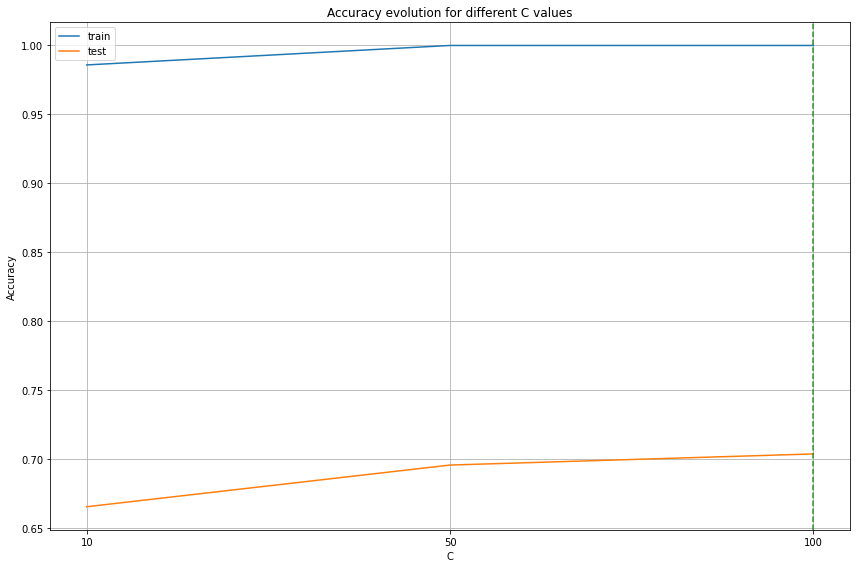

In [111]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()

plt.show()

# Conclusión

> Vemos que, de los modelos que hemos probado, el random forest nos da un accuracy razonable de 0.74, y por tanto es el mejor.

> He ido modificando los parámetros del vectorizer y la modificación de los resultados no es notable.

> Como mejora, podemos probar muchos más modelos, cambiando parámetros, eliminando palabras determinadas que puedan impactar en el accuracy, ampliando el procesamiento del texto, usando otros modelos de creación de características, ...
